# Qoreを用いたハーモニカの機種判別

QoreSDKを用いて10穴ハーモニカの機種を見分ける。  
見分ける対象はHohner製のMarineBandとSuzuki製のManji。

学習用データは、それぞれのハーモニカでの以下の演奏。
1. Walles Coleman's Liff (29 sec)
2. SecondLine Intro (12 sec)
3. Juke Intro (23 sec)
4. The Sailor & The Maid Intro (12 sec)

テスト用データは以下の演奏の別テイク。
1. Walles Coleman's Liff (29 sec)

by konkon

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import classification_report
import numpy as np
import glob
import QoreTrain

from qore_sdk.utils import sliding_window
from qore_sdk.featurizer import Featurizer
from qore_sdk.client import WebQoreClient

from pydub import AudioSegment
from scipy import signal

C:\Users\konkon\Anaconda3\envs\tf\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Manjiのトレーニングデータを取得&可視化

In [2]:
path = glob.glob('./train/Manji/*.wav')

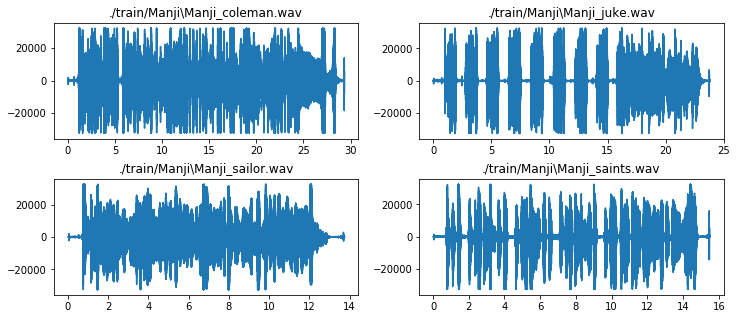

In [3]:
dataset = []
shapes = []
for p in path:
    sound = AudioSegment.from_file(p)
    data = np.array(sound.get_array_of_samples())
    dataset.append(data)
    shapes.append(data.shape[0])
    
fig = plt.figure(figsize=(12,5))
plt.subplots_adjust(hspace=0.35)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(path[i])
    x_range = np.linspace(0,dataset[i].shape[0]-1,dataset[i].shape[0])
    plt.plot(x_range/44100,dataset[i])

## トレーニングデータをだいたい1秒ごとに分割
* Sampling Rateは44100Hz。44000ごとに1つのデータとする。

In [4]:
X_train_manji,y_train_manji = QoreTrain.SplitTune(dataset,dec=0)

Width: 44000
12943 1281392 28
10485 1038090 23
6062 600145 13
6830 676177 15
Shape of separated dataset: (79, 44000)


## MarineBandのトレーニングデータを取得&可視化

In [5]:
path = glob.glob('./train/MarineBand/*.wav')

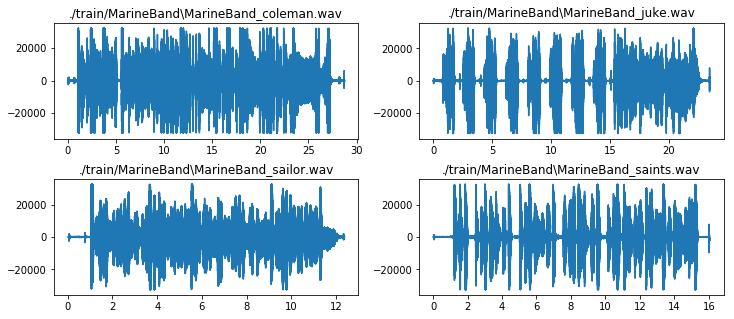

In [6]:
dataset = []
shapes = []
for p in path:
    sound = AudioSegment.from_file(p)
    data = np.array(sound.get_array_of_samples())
    dataset.append(data)
    shapes.append(data.shape[0])
    
fig = plt.figure(figsize=(12,5))
plt.subplots_adjust(hspace=0.35)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(path[i])
    x_range = np.linspace(0,dataset[i].shape[0]-1,dataset[i].shape[0])
    plt.plot(x_range/44100,dataset[i])

## トレーニングデータをだいたい1秒ごとに分割

In [7]:
X_train_marine,y_train_marine = QoreTrain.SplitTune(dataset,dec=1)

Width: 44000
12677 1255034 28
10342 1023897 23
5457 540334 12
7075 700508 15
Shape of separated dataset: (78, 44000)


## トレーニングデータを一つにまとめる
* y_trainで0はManji, 1はMarineBandを表す

In [8]:
X_train = np.vstack((X_train_manji,X_train_marine))
y_train = np.hstack((y_train_manji,y_train_marine))
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)

X_train.shape: (157, 44000)
y_train.shape: (157,)


## テストデータを取得&可視化

In [9]:
path = glob.glob('./test/*.wav')

Width: 44000
13424 1329039 29
Shape of separated dataset: (29, 44000)
Width: 44000
13107 1297612 29
Shape of separated dataset: (29, 44000)


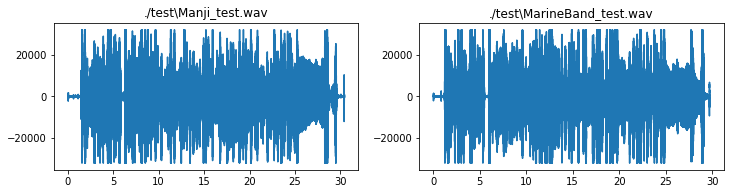

In [10]:
dataset = []
shapes = []
for p in path:
    sound = AudioSegment.from_file(p)
    data = np.array(sound.get_array_of_samples())
    dataset.append(data)
    shapes.append(data.shape[0])
    
fig = plt.figure(figsize=(12,2.7))
plt.subplots_adjust(hspace=0.35)
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.title(path[i])
    x_range = np.linspace(0,dataset[i].shape[0]-1,dataset[i].shape[0])
    plt.plot(x_range/44100,dataset[i])

#分割
X_test_manji,y_test_manji = QoreTrain.SplitTune([dataset[0]],dec=0)
X_test_marine,y_test_marine = QoreTrain.SplitTune([dataset[1]],dec=1)

## テストデータを一つにまとめる

In [11]:
X_test = np.vstack((X_test_manji,X_test_marine))
y_test = np.hstack((y_test_manji,y_test_marine))
print('X_train.shape:', X_test.shape)
print('y_train.shape:', y_test.shape)

X_train.shape: (58, 44000)
y_train.shape: (58,)


## それぞれの音声データをさらに分割
* qore_sdk.utilsのsliding_windowを使用

In [12]:
width = 11000
stepsize = 2000
X_train = sliding_window(X_train, width, stepsize)
X_test = sliding_window(X_test, width, stepsize)

print('X_train.shape:', X_train.shape)
print('X_test.shape:', X_test.shape)

X_train.shape: (157, 17, 11000)
X_test.shape: (58, 17, 11000)


## 音声データから特徴量抽出
* qore_sdk.utilsのFeaturizerを使用

In [13]:
n_filters = 20
featurizer = Featurizer(n_filters)
X_train = featurizer.featurize(X_train, axis=2)
X_test = featurizer.featurize(X_test, axis=2)

print('X_train.shape:', X_train.shape)
print('X_test.shape:', X_test.shape)

X_train.shape: (157, 17, 20)
X_test.shape: (58, 17, 20)


## 学習データをランダムに並べ替え

In [14]:
X_train,y_train,__ = QoreTrain.PermutateTrain(X_train,y_train)

## 学習開始
APIアカウント申請に関しては以下を参照  
https://qiita.com/advent-calendar/2019/quantumcore_reservoir

In [15]:
username = ''
password = ''
endpoint = ''

In [16]:
client = WebQoreClient(username, password, endpoint=endpoint)
client.classifier_train(X_train, y_train)

{'res': 'ok', 'train_time': 0.24289655685424805}

## トレーニングデータに対する検証

In [17]:
from sklearn.metrics import classification_report

res = client.classifier_predict(X_train)
report = classification_report(y_train, res['Y'])
print(report)

              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93        79
         1.0       0.91      0.95      0.93        78

   micro avg       0.93      0.93      0.93       157
   macro avg       0.93      0.93      0.93       157
weighted avg       0.93      0.93      0.93       157



## テストデータに対する検証

In [18]:
from sklearn.metrics import classification_report

res = client.classifier_predict(X_test)
report = classification_report(y_test, res['Y'])
print(report)

              precision    recall  f1-score   support

         0.0       0.86      0.83      0.84        29
         1.0       0.83      0.86      0.85        29

   micro avg       0.84      0.84      0.84        58
   macro avg       0.85      0.84      0.84        58
weighted avg       0.85      0.84      0.84        58



## 結果を可視化
* 青が正答した部分、赤が間違えた部分

Width: 44000
13424 1329039 29
Shape of separated dataset: (29, 44000)
Width: 44000
13424 1329039 29
Shape of separated dataset: (29, 44000)


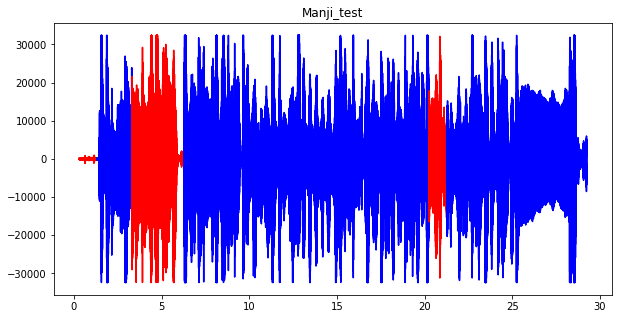

In [19]:
dec = res['Y'][:29]

fig = plt.figure(figsize=(10,5))
plt.title('Manji_test')
x_range = np.linspace(0,dataset[0].shape[0]-1,dataset[0].shape[0])
x_range,__ = QoreTrain.SplitTune([x_range],0,width=44000)
dataset_separate,__ = QoreTrain.SplitTune([dataset[0]],0,width=44000)
for x,d,r in zip(x_range,dataset_separate,dec):
    if(r == 0):
        plt.plot(x/44100,d,c='blue',label='Correct')
    elif(r == 1):
        plt.plot(x/44100,d,c='red',label='Wrong')
# plt.xlim(1,3)

Width: 44000
13107 1297612 29
Shape of separated dataset: (29, 44000)
Width: 44000
13107 1297612 29
Shape of separated dataset: (29, 44000)


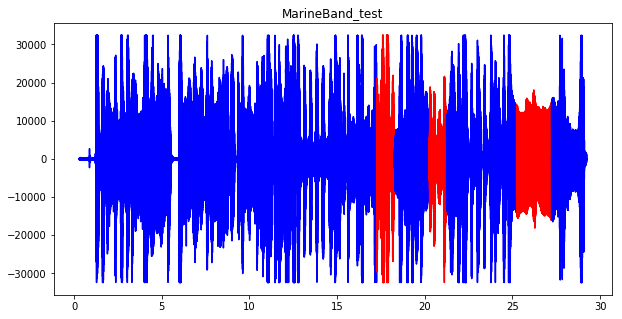

In [20]:
dec = res['Y'][29:]

fig = plt.figure(figsize=(10,5))
plt.title('MarineBand_test')
x_range = np.linspace(0,dataset[1].shape[0]-1,dataset[1].shape[0])
x_range,__ = QoreTrain.SplitTune([x_range],0,width=44000)
dataset_separate,__ = QoreTrain.SplitTune([dataset[1]],0,width=44000)
for x,d,r in zip(x_range,dataset_separate,dec):
    if(r == 1):
        plt.plot(x/44100,d,c='blue')
    elif(r == 0):
        plt.plot(x/44100,d,c='red')
# plt.xlim(1,3)